# Quads design (3dp pla + blue shims) for energy splitting between two target regions


## Imports

In [1]:
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"  # Use 8 CPU cores for JAX pmap 

from difflexmm.utils import save_data, load_data
from difflexmm.geometry import QuadGeometry, compute_inertia, compute_xy_limits
from difflexmm.energy import ligament_strains
from difflexmm.kinematics import block_to_node_kinematics
from difflexmm.plotting import generate_animation, plot_geometry
from problems.quads_focusing import ForwardProblem
from problems.quads_energy_splitting import OptimizationProblem
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
from typing import Optional, List

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)  # enable float64 type
# config.update("jax_log_compiles", 1)

plt.style.use(["science", "grid"])
%matplotlib widget


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Plotting functions


In [2]:
def plot_objective_and_constraints_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(nrows=3, figsize=figsize,
                             sharex=True, constrained_layout=True)
    axes[0].set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    axes[0].plot(jnp.array(optimization.objective_values) /
                 optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes[0].axhline(y=0, color="black")
    axes[1].set_ylabel("Overlap", fontsize=fontsize)
    axes[1].plot(optimization.constraints_violation["angles"],
                 lw=3, color="#c0392b")
    axes[1].axhline(y=0, color="black")
    axes[2].set_ylabel("Edge-length [mm]", fontsize=fontsize)
    axes[2].plot(optimization.constraints_violation["edge_lengths"],
                 lw=3, color="#c0392b")
    axes[2].axhline(y=0, color="black")
    axes[-1].set_xlabel(r"Iteration \#", fontsize=fontsize)
    # Change fontsize for all axes
    for ax in axes:
        ax.tick_params(labelsize=fontsize)
    if not grid:
        for ax in axes:
            ax.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_and_constraints_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def plot_objective_iterations(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, figsize=(10, 7), fontsize=None, grid=True):

    fig, axes = plt.subplots(
        figsize=figsize, sharex=True, constrained_layout=True)
    axes.plot(jnp.array(optimization.objective_values) /
              optimization.forward_problem.n_timepoints, lw=3, color="#16a085")
    axes.axhline(y=0, color="black")
    axes.set_xlabel(r"Iteration \#", fontsize=fontsize)
    axes.set_ylabel("Energy focused [mJ]", fontsize=fontsize)
    # Change fontsize for all axes
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)

    if optimization_filename is not None:
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/objective_iterations.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)


def plot_pareto_front(pareto_objectives_data: List, figsize=(4, 4), fontsize=14, ticksize=12, xlim=None, ylim=None, grid=True, colors=("#bdc3c7", "#bdc3c7")):
    fig, axes = plt.subplots(figsize=figsize, constrained_layout=True)
    # Create a radial color gradient
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
        "pareto",
        colors,
    )
    max_objective_value = max(
        [jnp.linalg.norm(objective_values_ray, axis=1).max()
         for objective_values_ray in pareto_objectives_data]
    )
    # Plot pareto front
    for objective_values_ray in pareto_objectives_data:
        axes.scatter(
            objective_values_ray[:, 0], objective_values_ray[:, 1],
            s=3,
            color=cmap(jnp.linalg.norm(
                objective_values_ray, axis=1)/max_objective_value),
        )
    axes.set_xlabel(r"Energy focused at T1 [mJ]", fontsize=fontsize)
    axes.set_ylabel(r"Energy focused at T2 [mJ]", fontsize=fontsize)
    axes.axis("equal")
    axes.tick_params(labelsize=ticksize)

    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if not grid:
        axes.grid(False)

    return fig, axes


def generate_response_animation(
        optimization: OptimizationProblem,
        optimization_filename: str,
        animation_filename: str = "response_animation",
        iteration=-1,
        field: str = "v",
        **plot_kwargs):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    if iteration >= 0:
        solution = optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )
    else:
        solution = optimization.forward_problem.solution_data if optimization.forward_problem.solution_data is not None else optimization.forward_problem.solve(
            optimization.design_values[iteration]
        )

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + optimization.forward_problem.spacing * jnp.array([[-1.25, 1.25], [-1., 1.]])

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    # Drop alien stuff from plot_kwargs
    plot_kwargs.pop("field", None)
    plot_kwargs.pop("animation_filename", None)
    plot_kwargs.pop("iteration", None)
    generate_animation(
        data=solution,
        field=field,
        out_filename=f"../out/{optimization.name}/{optimization_filename}/{animation_filename}_design_{iteration_label:03d}",
        deformed=True,
        xlim=xlim,
        ylim=ylim,
        **plot_kwargs
    )


def plot_design(optimization: OptimizationProblem, optimization_filename: Optional[str] = None, design_label: Optional[str] = None, iteration=-1, figsize=(10, 7), fontsize=None, grid=True, axis=True, field_values=None, cmap="inferno", color=None, cmap_label=None, scaling=1.):

    if not optimization.forward_problem.is_setup:
        optimization.forward_problem.setup()

    xlim, ylim = optimization.forward_problem.geometry.get_xy_limits(
        *optimization.design_values[iteration]) + 0.25*optimization.forward_problem.spacing * jnp.array([[-1., 1.], [-0.5, 0.5]])

    fig, axes = plot_geometry(
        block_centroids=optimization.forward_problem.geometry.block_centroids(
            *optimization.design_values[iteration]),
        centroid_node_vectors=optimization.forward_problem.geometry.centroid_node_vectors(
            *optimization.design_values[iteration]),
        bond_connectivity=optimization.forward_problem.geometry.bond_connectivity(),
        figsize=figsize,
        color="#2980b9",
        xlim=xlim,
        ylim=ylim,
    )
    axes.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
    axes.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
    # axes.set_aspect("equal")
    axes.tick_params(labelsize=fontsize)
    if not grid:
        axes.grid(False)
    if not axis:
        axes.axis("off")

    if field_values is not None and color is None:
        axes.collections[0].set_array(field_values)
        axes.collections[0].set_cmap(cmap)
        axes.collections[0].set_norm(
            matplotlib.colors.PowerNorm(
                gamma=scaling, vmin=jnp.min(field_values), vmax=jnp.max(field_values)
            )
        )
        cb = fig.colorbar(axes.collections[0], ax=axes, pad=0.01, aspect=30)
        cb.ax.tick_params(
            labelsize=0.8*fontsize if fontsize is not None else None)
        # Set ticklabels to have 1 decimal place
        cb.set_ticks(cb.get_ticks())
        cb.set_ticklabels([f"{tick:.1f}" for tick in cb.get_ticks()])
        cb.set_label(cmap_label, fontsize=fontsize)

    iteration_label = iteration if iteration >= 0 else len(
        optimization.design_values) + iteration
    if optimization_filename is not None:
        _design_label = f"design_{iteration_label:03d}_{design_label}" if design_label is not None else f"design_{iteration_label:03d}"
        path = Path(
            f"../out/{optimization.name}/{optimization_filename}/{_design_label}.png")
        # Make sure parents directories exist
        path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(str(path), dpi=300)

    return fig, axes


def kinetic_energy_per_block(velocity, blocks_inertia):
    # velocity is (n_time_steps, n_blocks, 3)
    # blocks_inertia is (n_blocks, 3)
    return 0.5*jnp.sum(velocity**2 * blocks_inertia, axis=-1)


def average_kinetic_energy_per_block(solution_data, blocks_inertia):
    return jnp.sum(
        kinetic_energy_per_block(
            solution_data.fields[:, 1],
            blocks_inertia,
        )/solution_data.timepoints.shape[0],
        axis=0,
    )


def compute_ligament_strains(block_displacement, centroid_node_vectors, bond_connectivity, reference_bond_vectors):
    node_displacements = block_to_node_kinematics(
        block_displacement,
        centroid_node_vectors
    ).reshape(-1, 3)
    return ligament_strains(node_displacements[bond_connectivity[:, 0]],
                            node_displacements[bond_connectivity[:, 1]],
                            reference_vector=reference_bond_vectors)


def plot_strains_and_kinetic_energy_evolution(optimization: OptimizationProblem, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap_strains="inferno", cmap_kinetic="inferno", show_ticks=True, time_label_pos="right"):
    problem = optimization.forward_problem
    solution_data = optimization.forward_problem.solution_data
    column_labels = ["Shear", "Bending", "Kinetic"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=len(timepoints), ncols=3, figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[0], column_labels):
        ax.set_title(label, fontsize=fontsize)
    # Remove all ticks
    if not show_ticks:
        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        # Add supxlabel at the bottom
        fig.supxlabel(r"$x$ [mm]", fontsize=fontsize,
                      x=0.55, y=0.1, ha="center", va="center")
        # Add supylabel on the right
        fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                      y=0.55, ha="left", va="center")
        for ax in axes[-1]:
            # ax.yaxis.set_label_position("right")
            # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, 0]:
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, -1]:
            # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)

    # Add time labels on the right
    if time_label_pos == "right":
        for ax, label in zip(axes[:, -1], time_labels):
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(label, fontsize=0.8*fontsize, labelpad=4)
    elif time_label_pos == "left":
        for ax, label in zip(axes[:, 0], time_labels):
            ax.set_ylabel(label, fontsize=0.8*fontsize, labelpad=4)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    velocities = [solution_data.fields[timepoint, 1]
                  for timepoint in timepoints]
    # Compute strain energy
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        for displacement in displacements]
    strain_fields = jnp.array(strain_fields)
    strain_energies = jnp.array([
        [problem.k_shear * (strain_fields_i[1]*problem.bond_length)
         ** 2/2, problem.k_rot*strain_fields_i[2]**2/2]
        for strain_fields_i in strain_fields
    ])
    # Strain energy values limits
    strain_energy_min, strain_energy_max = jnp.min(
        strain_energies), jnp.max(strain_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        kinetic_energy_per_block(
            velocity,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for velocity in velocities
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # energy_min, energy_max = min(strain_energy_min, kinetic_energy_min), max(strain_energy_max, kinetic_energy_max)

    # Plot strain energies in the first two
    for (ax0, ax1), (shear_energy, bending_energy) in zip(axes[:, :2], strain_energies):
        ax0.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], shear_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=matplotlib.colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
        ax1.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], bending_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=matplotlib.colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
    # Plot kinetic energies in the right column
    for ax, kinetic_energy in zip(axes[:, -1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap_kinetic, shading='gouraud',
            norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                             vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    # Remove all ticks and axes labels
    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])

    strain_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
                                        cmap=cmap_strains)
    kinetic_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max,),
                                         cmap=cmap_kinetic)
    cb_strains = fig.colorbar(strain_mappable, ax=axes[-1, :2], pad=0.25 if show_ticks else 0.08, aspect=25,
                              orientation="horizontal", location="bottom")
    cb_strains.ax.tick_params(labelsize=0.8*fontsize)
    cb_strains.set_label(r"Strain energy [mJ]", fontsize=fontsize)
    cb_kinetic = fig.colorbar(kinetic_mappable, ax=axes[-1, -1], pad=0.25 if show_ticks else 0.08, aspect=25*0.47,
                              orientation="horizontal", location="bottom")
    cb_kinetic.ax.tick_params(labelsize=0.8*fontsize)
    cb_kinetic.set_label(r"Kinetic energy [mJ]", fontsize=fontsize)

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes


def plot_strains_and_kinetic_energy_evolution_T(optimization: OptimizationProblem, timepoints: List[int], xlim=None, ylim=None, figsize=(7.8, 5), fontsize=14, grid=True, cmap_strains="inferno", cmap_kinetic="inferno", show_ticks=True, time_label_pos="right"):
    # Same as plot_strains_and_kinetic_energy_evolution but transposed
    problem = optimization.forward_problem
    solution_data = optimization.forward_problem.solution_data
    column_labels = ["Shear", "Bending", "Kinetic"]
    time_labels = [
        f"$t$ = {solution_data.timepoints[timepoint]*1e3:.0f}ms" for timepoint in timepoints]
    fig, axes = plt.subplots(nrows=3, ncols=len(timepoints), figsize=figsize,
                             sharex=True, sharey=True, constrained_layout=True)

    for ax, label in zip(axes[0], time_labels):
        ax.set_title(label, fontsize=fontsize)
    # Remove all ticks
    if not show_ticks:
        for ax in axes.flatten():
            ax.set_xticks([])
            ax.set_yticks([])
    else:
        # Add supxlabel at the bottom
        fig.supxlabel(r"$x$ [mm]", fontsize=fontsize,
                      x=0.55, y=0.1, ha="center", va="center")
        # Add supylabel on the right
        fig.supylabel(r"$y$ [mm]", fontsize=fontsize,
                      y=0.55, ha="left", va="center")
        for ax in axes[-1]:
            # ax.yaxis.set_label_position("right")
            # ax.set_ylabel(r"$y$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, 0]:
            ax.tick_params(labelsize=0.8*fontsize)
        for ax in axes[:, -1]:
            # ax.set_xlabel(r"$x$ [mm]", fontsize=fontsize)
            ax.tick_params(labelsize=0.8*fontsize)

    # Add time labels on the right
    if time_label_pos == "right":
        for ax, label in zip(axes[:, -1], column_labels):
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(label, fontsize=fontsize, labelpad=4)
    elif time_label_pos == "left":
        for ax, label in zip(axes[:, 0], column_labels):
            ax.set_ylabel(label, fontsize=fontsize, labelpad=4)

    block_points = (
        solution_data.block_centroids[:, None] + solution_data.centroid_node_vectors).reshape(-1, 2)
    reference_bond_vectors = block_points[solution_data.bond_connectivity[:, 1]] - \
        block_points[solution_data.bond_connectivity[:, 0]]
    bond_midpoints = jnp.mean(
        block_points[solution_data.bond_connectivity], axis=1)

    displacements = [solution_data.fields[timepoint, 0]
                     for timepoint in timepoints]
    velocities = [solution_data.fields[timepoint, 1]
                  for timepoint in timepoints]
    # Compute strain energy
    strain_fields = [
        compute_ligament_strains(
            displacement, solution_data.centroid_node_vectors, solution_data.bond_connectivity, reference_bond_vectors)
        for displacement in displacements]
    strain_fields = jnp.array(strain_fields)
    strain_energies = jnp.array([
        [problem.k_shear * (strain_fields_i[1]*problem.bond_length)
            ** 2/2, problem.k_rot*strain_fields_i[2]**2/2]
        for strain_fields_i in strain_fields
    ])
    # Strain energy values limits
    strain_energy_min, strain_energy_max = jnp.min(
        strain_energies), jnp.max(strain_energies)

    # Compute kinetic energy
    kinetic_energies = jnp.array([
        kinetic_energy_per_block(
            velocity,
            compute_inertia(
                vertices=solution_data.centroid_node_vectors, density=problem.density),
        ) for velocity in velocities
    ])
    # Kinetic energy values limits
    kinetic_energy_min, kinetic_energy_max = jnp.min(
        kinetic_energies), jnp.max(kinetic_energies)

    # Plot strain energies in the first two
    for (ax0, ax1), (shear_energy, bending_energy) in zip(axes[:2].T, strain_energies):
        ax0.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], shear_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=matplotlib.colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
        ax1.tripcolor(
            bond_midpoints[:, 0], bond_midpoints[:, 1], bending_energy,
            cmap=cmap_strains, shading='gouraud',
            # gamma=1./2. for sqrt
            norm=matplotlib.colors.PowerNorm(
                gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
        )
    # Plot kinetic energies in the right column
    for ax, kinetic_energy in zip(axes[-1], kinetic_energies):
        ax.tripcolor(
            solution_data.block_centroids[:,
                                          0], solution_data.block_centroids[:, 1], kinetic_energy,
            cmap=cmap_kinetic, shading='gouraud',
            norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min,
                                             vmax=kinetic_energy_max,),  # gamma=1./2. for sqrt
        )

    if xlim is None:
        xlim = compute_xy_limits(block_points)[0]
    if ylim is None:
        ylim = compute_xy_limits(block_points)[1]
    for ax in axes.flatten():
        ax.set(xlim=xlim, ylim=ylim)
        # ax.axis("equal")

    # Remove all ticks and axes labels
    # for ax in axes.flatten():
    #     ax.set_xticks([])
    #     ax.set_yticks([])
    #     ax.set_xticklabels([])
    #     ax.set_yticklabels([])

    strain_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=strain_energy_min, vmax=strain_energy_max,),
                                        cmap=cmap_strains)
    kinetic_mappable = cm.ScalarMappable(norm=matplotlib.colors.PowerNorm(gamma=1./2., vmin=kinetic_energy_min, vmax=kinetic_energy_max,),
                                         cmap=cmap_kinetic)
    cb_strains = fig.colorbar(strain_mappable, ax=axes[:2, -1], pad=0.25 if show_ticks else 0.11, aspect=25,
                              orientation="vertical", location="right")
    cb_strains.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    cb_strains.set_label(r"[mJ]", fontsize=fontsize)
    cb_kinetic = fig.colorbar(kinetic_mappable, ax=axes[-1, -1], pad=0.25 if show_ticks else 0.11, aspect=25*0.47,
                              orientation="vertical", location="right")
    cb_kinetic.ax.tick_params(labelsize=0.8*fontsize, pad=2.)
    cb_kinetic.set_label(r"[mJ]", fontsize=fontsize)

    fig.align_ylabels([cb_strains.ax, cb_kinetic.ax])

    if not grid:
        for ax in axes.flatten():
            ax.grid(False)

    return fig, axes

## Optimal design and response


In [3]:
# NOTE: Units are mm, N, s

# Geometrical params
n1_blocks = 24
n2_blocks = 16
spacing = 15.  # 1.0  # 15 mm
hinge_length = 0.15*spacing  # Same as bond length
initial_angle = 25*jnp.pi/180
horizontal_shifts, vertical_shifts = QuadGeometry(n1_blocks, n2_blocks, spacing=spacing, bond_length=hinge_length).get_design_from_rotated_square(
    angle=initial_angle,
)  # Initial design

# Mechanical params
k_stretch = 120.  # stretching stiffness 120. N/mm
k_shear = 1.19  # shearing stiffness 1.19 N/mm
k_rot = 1.50  # rotational stiffness 1.50 Nmm
density = 6.18e-9  # Mg/mm^2
# NOTE: Damping is assumed to be the same for all blocks as it is small enough that the inertia change during optimization is negligible.
# The reference is taken to be zero angle rotated square geometry.
# 0.36125, 0.02175026 = mass and inertia of a single square of zero angle and unitary spacing and density and 0.15 bond length.
damping = 0.0186 * jnp.array([
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.36125 * density * spacing**2 * k_shear)**0.5,
    2 * (0.02175026 * density * spacing**4 * k_rot)**0.5
]) * jnp.ones((n1_blocks*n2_blocks, 3))

# Dynamic loading
amplitude = 0.5 * spacing
loading_rate = 30.  # Hz loading frequency for dynamic input

# Forward problem
problem = ForwardProblem(
    # Geometrical params
    n1_blocks=n1_blocks,
    n2_blocks=n2_blocks,
    spacing=spacing,
    bond_length=hinge_length,
    # Mechanical params
    k_stretch=k_stretch,
    k_shear=k_shear,
    k_rot=k_rot,
    density=density,
    damping=damping,
    use_contact=True,
    k_contact=k_rot,
    min_angle=-15*jnp.pi/180,
    cutoff_angle=-10*jnp.pi/180,
    # Dynamic loading
    amplitude=amplitude,
    loading_rate=loading_rate,
    input_delay=0.1*loading_rate**-1,
    n_excited_blocks=2,
    loaded_side="left",
    input_shift=0,
    # Analysis params
    simulation_time=2*loading_rate**-1,  # s
    n_timepoints=200,
    # Solver tolerances
    atol=1e-4,
    # Problem name (folder name)
    name="quads_energy_splitting_3dp_pla_shims",
)

# Optimization problem
target_sizes = ((2, 2), (2, 2))
target_shifts = ((5, 3), (-3, -3))
weights = (0.5, 0.5)  # (Focusing, Focusing) # NOTE: Negative weights mean protection.
optimization = OptimizationProblem(
    forward_problem=problem,
    target_sizes=target_sizes,
    target_shifts=target_shifts,
    weights=weights,
    name=problem.name,
)

problem_filename = f"quads{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_blocks}x{problem.n2_blocks}_excited_blocks_{problem.n_excited_blocks}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}_initial_angle_{initial_angle*180/jnp.pi:.1f}"
optimization_filename = f"opt_with_angle_30_and_length_3_constraints_{problem_filename}_target_sizes_{optimization.target_sizes}_target_shifts_{optimization.target_shifts}_weights_{optimization.weights}"


### Import most recent optimization object


In [ ]:
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Run optimization


In [ ]:
optimization.run_optimization_nlopt(
    initial_guess=(horizontal_shifts, vertical_shifts),
    # initial_guess=optimization.design_values[-1],
    n_iterations=80,
    min_block_angle=30*jnp.pi/180,
    min_void_angle=0*jnp.pi/180,
    min_edge_length=3.,  # mm
    max_time=8*60*60,  # 8 hour
    # lower_bound=-0.22*optimization.forward_problem.spacing,
    # upper_bound=0.22*optimization.forward_problem.spacing,
)

save_data(
    f"../data/{optimization.name}/{optimization_filename}.pkl",
    optimization.to_dict()  # Optimization problem
)


## Plots


In [ ]:
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/{optimization_filename}.pkl",
    )
)


### Objective iterations

In [ ]:
plot_objective_and_constraints_iterations(
    optimization,
    optimization_filename=optimization_filename,
    figsize=(7, 6),
    fontsize=14,
)


### Response animation


In [ ]:
# Best design
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=optimization_filename,
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=-1,
)


## Pareto results


In [5]:
pareto_folder = f"opt_with_angle_30_and_length_3_constraints_quads{'_linearized_strains' if problem.linearized_strains else ''}_{problem.n1_blocks}x{problem.n2_blocks}_excited_blocks_{problem.n_excited_blocks}_amplitude_{problem.amplitude:.2f}_loading_rate_{problem.loading_rate:.2f}_input_shift_{problem.input_shift}_target_sizes_{optimization.target_sizes}_target_shifts_{optimization.target_shifts}"

### Sampled Pareto front

In [6]:
# Import optimization data files from pareto folder
pareto_objectives_data = []
for path in Path(f"../data/{optimization.name}/pareto/{pareto_folder}/").glob("*.pkl"):
    optimization = OptimizationProblem.from_dict(load_data(path))
    pareto_objectives_data.append(
        jnp.array(optimization.objective_values_individual) /
        optimization.forward_problem.n_timepoints
    )

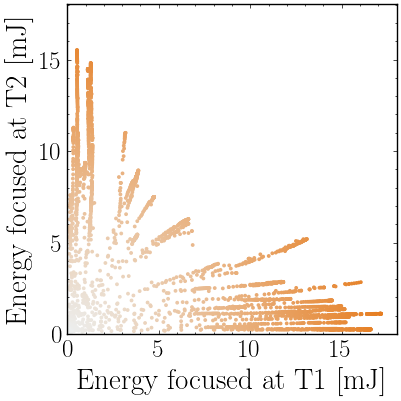

In [7]:
fig, axes = plot_pareto_front(
    pareto_objectives_data,
    figsize=(4, 4),
    xlim=(0, 18),
    ylim=(0, 18),
    fontsize=21,
    ticksize=18,
    grid=False,
    colors=("#ecf0f1", "#e67e22"),
)
# Make spines thicker
for spine in axes.spines.values():
    spine.set_linewidth(1)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/pareto_front.png",
    dpi=300,
)

### Best 50/50 split

In [63]:
pareto_data_filename = f"paretoSample_weights_0.599_0.401_iniAngle_35.0"
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/pareto/{pareto_folder}/{pareto_data_filename}.pkl",
    )
)
print(f"Objective ratios: {jnp.array(optimization.objective_values_individual).T[0]/jnp.array(optimization.objective_values_individual).T[1]}")

Objective ratios: [0.33490634 0.33663844 0.30709176 0.28153323 0.24173485 0.28584713
 0.63463371 0.49973929 0.96631749 0.85763267 0.68958689 0.97093655
 0.90806563 0.93392272 0.9540886  0.95321734 0.96527603 0.98806101
 0.98868115 0.99206314 0.99681512 0.99519539 1.00076012 1.01167405
 0.99887854 0.99866627 0.99846677 0.99894357 1.00954001 1.01937295
 1.01707023 1.01798012 1.01863026 1.01935816 1.02141664 1.02211449
 1.02359097 1.02449166 1.02617226 1.02712761 1.02872523 1.02978695
 1.03027606 1.03085182 1.03227669 1.0327968  1.03402261 1.03453303
 1.03573821 1.03646007 1.03760397 1.03854102 1.03946439 1.04036108
 1.04102636 1.04168931 1.04244748 1.04297456 1.04806045 1.05332131
 1.05673333 1.04918702 1.04756151 1.04837588 1.04972072 1.05172108
 1.05338168 1.05357671 1.05341593 1.0534222  1.05342254 1.05342266
 1.0534229  1.05341522 1.05340694 1.05344409 1.05328501 1.05338748
 1.05341509]


#### Plot design

(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

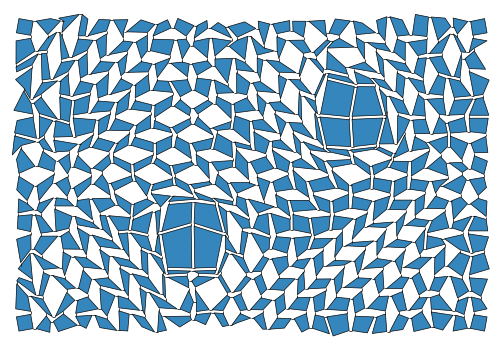

In [126]:
plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    figsize=(5, 3.5),
    axis=False
)


#### Plot average kinetic energy distribution


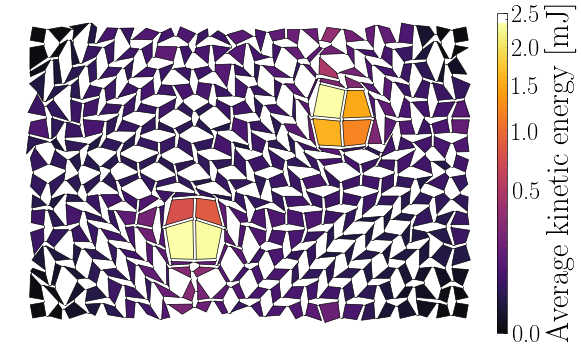

In [177]:
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    design_label="average_kinetic_energy",
    figsize=(5.8, 3.5),
    field_values=average_kinetic_energy_per_block(
        optimization.forward_problem.solution_data,
        compute_inertia(
            vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    scaling=0.5,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
)

#### Plot energy maps evolution


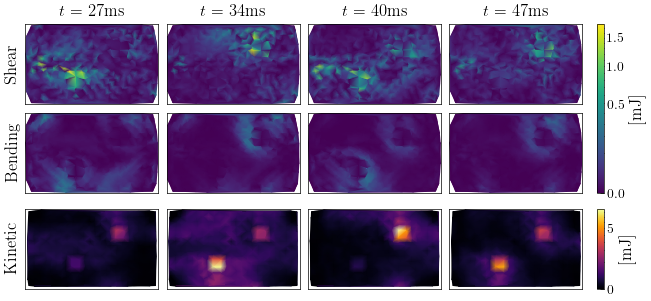

In [64]:
fig, axes = plot_strains_and_kinetic_energy_evolution_T(
    optimization,
    [80, 100, 120, 140],
    grid=False,
    figsize=(6.5, 3.),
    cmap_strains="viridis",
    show_ticks=False,
    fontsize=12,
    time_label_pos="left",
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}/strains_and_kinetic_energy_evolution.png",
    dpi=300,
)

#### Response animation

In [ ]:
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=f"pareto/{pareto_folder}/best_design_50_50_{pareto_data_filename}",
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=-1,
)


### Best 30/70 split

In [65]:
pareto_data_filename = "paretoSample_weights_0.300_0.700_iniAngle_15.0"
optimization = OptimizationProblem.from_dict(
    load_data(
        f"../data/{optimization.name}/pareto/{pareto_folder}/{pareto_data_filename}.pkl",
    )
)
print(f"Objective ratios: {jnp.array(optimization.objective_values_individual).T[0]/jnp.array(optimization.objective_values_individual).T[1]}")

Objective ratios: [0.7904543  0.77858822 0.71974196 0.65440657 0.80729018 0.77108672
 0.79051423 0.83817571 0.60988815 0.65622796 0.54930972 0.53618156
 0.60887145 0.49536423 0.51295492 0.49073743 0.48660996 0.44492238
 0.48207369 0.43568159 0.42607023 0.41696122 0.41187299 0.40494005
 0.39970395 0.39506984 0.36649397 0.36649291 0.45420838 0.3805014
 0.36394699 0.35382024 0.35382085 0.35382153 0.32881287 0.34376358
 0.3177203  0.3168365  0.30419628 0.30644436 0.29978629 0.29778698
 0.29761387 0.29531078 0.29314978 0.29250569 0.29132292 0.28922764
 0.28912107 0.28862592 0.2884147  0.28747706 0.29039356]


#### Plot design


(<Figure size 500x350 with 1 Axes>,
 <Axes: xlabel='$x$ [mm]', ylabel='$y$ [mm]'>)

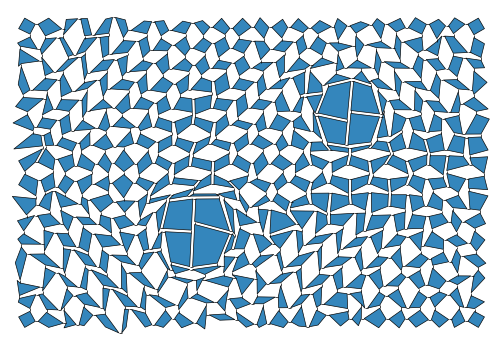

In [132]:
plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_30_70_{pareto_data_filename}",
    figsize=(5, 3.5),
    axis=False
)


#### Plot average kinetic energy distribution


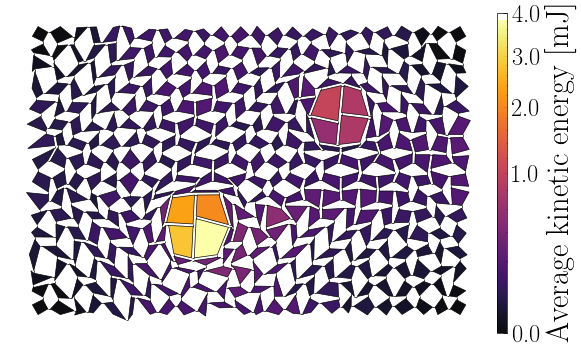

In [179]:
fig, axes = plot_design(
    optimization=optimization,
    optimization_filename=f"pareto/{pareto_folder}/best_design_30_70_{pareto_data_filename}",
    design_label="average_kinetic_energy",
    figsize=(5.8, 3.5),
    field_values=average_kinetic_energy_per_block(
        optimization.forward_problem.solution_data,
        compute_inertia(
            vertices=optimization.forward_problem.solution_data.centroid_node_vectors,
            density=optimization.forward_problem.density,
        )
    ),
    scaling=0.5,
    cmap="inferno",
    cmap_label="Average kinetic energy [mJ]",
    fontsize=22,
    grid=False,
    axis=False,
)

#### Plot energy maps evolution

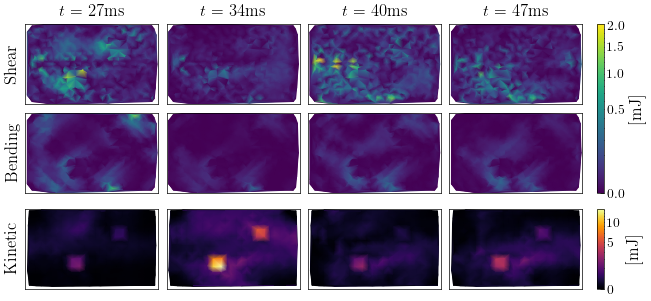

In [66]:
fig, axes = plot_strains_and_kinetic_energy_evolution_T(
    optimization,
    [80, 100, 120, 140],
    grid=False,
    figsize=(6.5, 3.),
    cmap_strains="viridis",
    show_ticks=False,
    fontsize=12,
    time_label_pos="left",
)
fig.savefig(
    f"../out/{optimization.name}/pareto/{pareto_folder}/best_design_30_70_{pareto_data_filename}/strains_and_kinetic_energy_evolution.png",
    dpi=300,
)

#### Response animation


In [ ]:
generate_response_animation(
    optimization,
    field="v",  # Velocity field
    optimization_filename=f"pareto/{pareto_folder}/best_design_30_70_{pareto_data_filename}",
    figsize=(8, 7.35*(optimization.forward_problem.n2_blocks)/optimization.forward_problem.n1_blocks),
    fontsize=14,
    fps=30,
    dpi=300,
    legend_label="Velocity [mm/s]",
    cmap="inferno",
    animation_filename="response_animation_no_grid",
    axis=False,
    iteration=-1,
)
